# Conditional variational autoencoder (using the VAE class)

# SETUP

In [1]:
!python --version


Python 3.6.7


In [2]:
%%bash
git clone https://github.com/masa-su/pixyz.git

fatal: destination path 'pixyz' already exists and is not an empty directory.


In [3]:
!apt-get update && apt-get install ffmpeg

Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Ign:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  Release
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  Release
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.4-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 62 not upgraded.


In [4]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
!pip install tensorboardX
!pip install -e pixyz --process-dependency-links
torch.cuda.is_available()

Obtaining file:///content/pixyz
DEPRECATION: Dependency Links processing has been deprecated and will be removed in a future release. A possible replacement is PEP 508 URL dependencies. You can find discussion regarding this at https://github.com/pypa/pip/issues/4187.
  Found existing installation: pixyz 0.0.2
    Can't uninstall 'pixyz'. No files were found to uninstall.
  Running setup.py develop for pixyz


True

# CVAE

generative process

2dimention data

c=f(ut,s(t-1))

st~p(st|ut, s(t-1))=N(c , sigma)

ot~p(ot|st)=N(st,sigma)

それぞれの分散共分散行列には対角行列を使用（制御がめんどそうだから

In [1]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tensorboardX import SummaryWriter
import numpy as np

from tqdm import tqdm

batch_size = 128
epochs =100#10
seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [2]:
root = '../data'
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambd=lambda o: o.view(-1))])
kwargs = {'batch_size': batch_size, 'num_workers': 1, 'pin_memory': True}

# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST(root=root, train=True, transform=transform, download=True),
#     shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST(root=root, train=False, transform=transform),
#     shuffle=False, **kwargs)

In [3]:
from pixyz.distributions import Normal, Bernoulli
from pixyz.losses import KullbackLeibler
from pixyz.models import VAE

In [4]:
#function for generate data
import torch.distributions as dist

def origin_datagenerator(sample_num,dsigma,axis):
  ca_axis=[-3,-2]
  cb_axis=[3,3]
  cc_axis=[7,5]
  
  data_cso={}
  
  ones=torch.ones(int(sample_num/3))
  
  sample_ca = torch.stack([ones*axis[0][0],ones*axis[0][1]],1)
  sample_cb = torch.stack([ones*axis[1][0],ones*axis[1][1]],1)
  sample_cc = torch.stack([ones*axis[2][0],ones*axis[2][1]],1)
  data_cso.update({"c":torch.cat([sample_ca,sample_cb,sample_cc],dim=0)})
  data_cso.update({"s":dist.Normal(data_cso["c"],dsigma).sample()})
  data_cso.update({"o":dist.Normal(data_cso["s"],dsigma).sample()})
#   data_cso.update([ ("c",torch.cat([sample_ca,sample_cb,sample_cc],dim=0)), ("s",dist.Normal(data_cso["c"],dsigma).sample()) ])
  
  return data_cso
  
#
def unique_datagenerator(sample_num,dsigma,u_fragx,u_fragy):
    data_cso={}
    
    #st-1
    sample_sx=torch.rand(sample_num)*200-100#-100~100の範囲で一様分布#一旦0~100
    sample_sy=torch.rand(sample_num)*200-100
    st1=torch.cat([sample_sx.view(sample_num,1),sample_sy.view(sample_num,1)],dim=1)
    print(st1)
    
    if u_fragx == 0.0 and u_fragy ==0.0:
        #ut
        sample_ux=torch.rand(sample_num)*20-10#移動距離は-10~10
        sample_uy=torch.rand(sample_num)*20-10
        ut=torch.cat([sample_ux.view(sample_num,1),sample_uy.view(sample_num,1)],dim=1)
        print(ut)
    else:
        sample_ux=torch.ones(sample_num)*u_fragx#移動距離は-10~10
        sample_uy=torch.ones(sample_num)*u_fragy
        ut=torch.cat([sample_ux.view(sample_num,1),sample_uy.view(sample_num,1)],dim=1)
        print(ut)
        
    #その他
    sample_c=st1+ut

    print(sample_c)
    data_cso.update({"st1":st1})#t-1時刻の位置
    data_cso.update({"u":ut})#制御
    data_cso.update({"c":sample_c})#動作モデルを通したs(分散なし)
    data_cso.update({"s":dist.Normal(data_cso["c"],dsigma).sample()})#真の位置(分散を通している)
    data_cso.update({"o":dist.Normal(data_cso["s"],dsigma).sample()})#計測値（stと同じ位置だが，分散が載っている

    return data_cso

In [5]:
sample_num=5000
ssigma=torch.Tensor([0.3,0.3]*sample_num).view(sample_num,2)#状態遷移時の分散
osigma=torch.Tensor([0.3,0.3]*sample_num).view(sample_num,2)#計測情報の分散

axis=[[-3,-2],[3,3],[7,5]]#originalの場合の点の指定

max_data=110.0
min_data=-110.0

data=unique_datagenerator(sample_num,ssigma,0.0,0.0)
test_data=unique_datagenerator(sample_num,ssigma,0.0,0.0)

print(data)

train = torch.utils.data.TensorDataset(data["o"], data["c"])
train_loader = torch.utils.data.DataLoader(train, shuffle=False,**kwargs)
test = torch.utils.data.TensorDataset(test_data["o"], test_data["c"])
test_loader = torch.utils.data.DataLoader(test, shuffle=False,**kwargs)

tensor([[ 51.5263,   6.5352],
        [-44.1378,  12.8848],
        [-19.3861,  31.2099],
        ...,
        [  5.6362, -15.1425],
        [ 51.6001, -83.7875],
        [ 82.0914,  56.8778]])
tensor([[ 5.2281, -4.2568],
        [ 4.7824, -5.2771],
        [ 2.7146, -7.0110],
        ...,
        [-0.8935, -0.4212],
        [ 4.5072, -4.4959],
        [-7.4503,  1.1896]])
tensor([[ 56.7544,   2.2785],
        [-39.3554,   7.6076],
        [-16.6715,  24.1989],
        ...,
        [  4.7427, -15.5637],
        [ 56.1073, -88.2834],
        [ 74.6412,  58.0675]])
tensor([[-42.9359,  -6.1523],
        [ 35.3621,  44.9553],
        [ 29.2753, -44.0143],
        ...,
        [ 68.5273, -12.1192],
        [-41.2896,  72.7900],
        [ -9.8963,  45.8641]])
tensor([[-2.7713, -5.2977],
        [-8.4640, -6.2876],
        [ 4.4588, -2.6723],
        ...,
        [-8.3775,  8.3523],
        [ 1.2609,  3.9167],
        [-1.5893,  8.0012]])
tensor([[-45.7071, -11.4500],
        [ 26.8981,  38.6

In [6]:
o_dim = 2
c_dim = 2
s_dim = 2


# inference model q(z|x,y)
class Inference(Normal):
    def __init__(self):
        super(Inference, self).__init__(cond_var=["o","c"], var=["s"], name="q")

        self.fc1 = nn.Linear(o_dim+c_dim, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc31 = nn.Linear(4, s_dim)
        self.fc32 = nn.Linear(4, s_dim)

    def forward(self, o, c):
        h = F.relu(self.fc1( torch.cat([o,c],1) ))
        h = F.relu(self.fc2(h))        
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

    
# generative model p(x|z,y)    
class Generator(Bernoulli):
    def __init__(self):
        super(Generator, self).__init__(cond_var=["s"], var=["o"], name="p")

        self.fc1 = nn.Linear(s_dim, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, o_dim)

    def forward(self, s):
#         print(s)
#         print(s.shape)
        h = F.relu(self.fc1(s))
        h = F.relu(self.fc2(h))
        return {"probs": torch.sigmoid(self.fc3(h))}
    
class Generator2(Normal):
    def __init__(self):
        super().__init__(cond_var=["s"], var=["o"], name="p")

        self.fc1 = nn.Linear(s_dim, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, o_dim)

    def forward(self, s):
#         print(s)
#         print(s.shape)
        h = F.relu(self.fc1(s))
        h = F.relu(self.fc2(h))
        return {"loc": self.fc3(h),"scale":0.3}

#     def forward(self, s, c):
#         print(s)
#         print(c.view(1))
#         c=c.view(1)
#         print(s.shape)
#         print(c.shape)
#         print(s.size())
#         print(c.size())
#         sc=[]
#         sc.append(s)
#         sc.append(c)
#         aa=self.fc1(torch.stack(sc, 0))
#         h = F.relu(aa)
#         h = F.relu(self.fc2(h))
#         return {"probs": torch.sigmoid(self.fc3(h))}

      
    

# prior = Normal(loc=loc, scale=scale, cond_var=["c"],var=["s"], dim=s_dim, name="p_prior")

In [7]:
# prior model p(z|c)
class prior_set(Normal):
    def forward(self, c):
        return{"loc":c, "scale":torch.tensor([0.5,0.5]).to(device)}
      
prior = prior_set(cond_var=["c"],var=["s"], dim=s_dim, name="p_prior")
print(prior)

Distribution:
  p_prior(s|c) (Normal)
Network architecture:
  prior_set()


In [8]:
p = Generator2()
q = Inference()

p.to(device)
q.to(device)

print(p)
print(q)

Distribution:
  p(o|s) (Normal)
Network architecture:
  Generator2(
    (fc1): Linear(in_features=2, out_features=4, bias=True)
    (fc2): Linear(in_features=4, out_features=4, bias=True)
    (fc3): Linear(in_features=4, out_features=2, bias=True)
  )
Distribution:
  q(s|o,c) (Normal)
Network architecture:
  Inference(
    (fc1): Linear(in_features=4, out_features=4, bias=True)
    (fc2): Linear(in_features=4, out_features=4, bias=True)
    (fc31): Linear(in_features=4, out_features=2, bias=True)
    (fc32): Linear(in_features=4, out_features=2, bias=True)
  )


In [9]:
kl = KullbackLeibler(q, prior)
print(kl)

KL[q(s|o,c)||p_prior(s|c)]


In [10]:
model = VAE(q, p, regularizer=kl, optimizer=optim.Adam, optimizer_params={"lr":1e-3})
print(model)

Distributions (for training): 
  q(s|o,c), p(o|s) 
Loss function: 
  mean(-E_q(s|o,c)[log p(o|s)] + KL[q(s|o,c)||p_prior(s|c)]) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.001
      weight_decay: 0
  )


In [11]:
def train(epoch):
    train_loss = 0
    for o,c in tqdm(train_loader):
        o = o.to(device)
        c = c.to(device)
#         print(o.size())
#         print(c.size())
#         print(o)
        loss = model.train({"o": o, "c": c})
        train_loss += loss
        
#     print(kl.gauss_gauss_kl(, scale1, loc2, scale2, dim=None))
    train_loss = train_loss * train_loader.batch_size / len(data["c"])
    print('Epoch: {} Train loss: {:.4f}'.format(epoch, train_loss))
    return train_loss

In [12]:
# print(train_loader.batch_size)
# print(len(train_loader))
# print(dc)

In [13]:
def test(epoch):
    test_loss = 0
    for o, c in test_loader:
        o = o.to(device)
        c = c.to(device)
        loss = model.test({"o": o, "c": c})
        test_loss += loss
        

    test_loss = test_loss * test_loader.batch_size / len(test_data["c"])
    print('Test loss: {:.4f}'.format(test_loss))
    return test_loss

In [14]:
# model.test({"o":do[0].unsqueeze(0).to(device),"c":dc[0].unsqueeze(0).to(device)})
# q.sample("o":do[0],"c":dc[0], return_all=False)

In [15]:
def plot_reconstrunction(o, c):
    with torch.no_grad():
        s = q.sample({"o": o, "c": c}, return_all=False)
        s.update({"c": c})
        recon_batch = p.sample_mean(s).view(-1, 1, 28, 28)
    
        recon = torch.cat([o.view(-1, 1, 28, 28), recon_batch]).cpu()
        return recon
    
def plot_image_from_latent(s, c):
    with torch.no_grad():
        sample = p.sample_mean({"s": s, "c": c}).view(-1, 1, 28, 28).cpu()
        return sample
    
def plot_reconstrunction_changing_y(o, c):
    c_change = torch.eye(10)[range(7)].to(device)
    batch_dummy = torch.ones(o.size(0))[:, None].to(device)    
    recon_all = []
    
    with torch.no_grad():
        for _c in c_change:
            s = q.sample({"o": o, "c": c}, return_all=False)
            s.update({"c": batch_dummy * _c[None,:]})
            recon_batch = p.sample_mean(s).view(-1, 1, 28, 28)
            recon_all.append(recon_batch)
    
        recon_changing_c = torch.cat(recon_all)
        recon_changing_c = torch.cat([o.view(-1, 1, 28, 28), recon_changing_c]).cpu()
        return recon_changing_c

In [16]:
#prepare for plot
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import HTML
history = {"train_loss":[],"test_loss":[]}

ims=[]#animation variable
# sample_s=dist.Normal(dc,dsigma).sample()
# sample_o=dist.Normal(sample_s,dsigma).sample()

grid_inter=20.0

plt.xlim([min_data,max_data])
plt.ylim([min_data,max_data])

plt.xlabel('$sx$', fontsize=16)
plt.ylabel('$sy$', fontsize=16)
plt.title("Simulated dataset")

# plt.xticks(np.arange(-2,6,1.0))

Text(0.5, 1.0, 'Simulated dataset')

100%|██████████| 40/40 [00:00<00:00, 150.36it/s]

Epoch: 1 Train loss: 51998.0156


Test loss: 51757.9062


/home/fukku/anaconda3/envs/pixyz/lib/python3.6/site-packages/matplotlib/mathtext.py:843: MathTextWarning: Font 'rm' does not have a glyph for '\u3000' [U+3000], substituting with a dummy symbol.
  MathTextWarning)


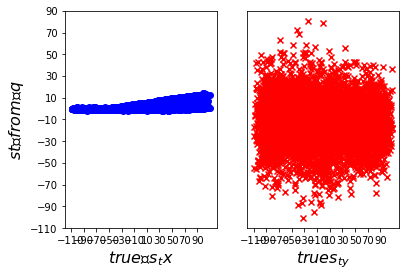

100%|██████████| 40/40 [00:00<00:00, 149.95it/s]

Epoch: 2 Train loss: 51422.0547


Test loss: 50833.0352


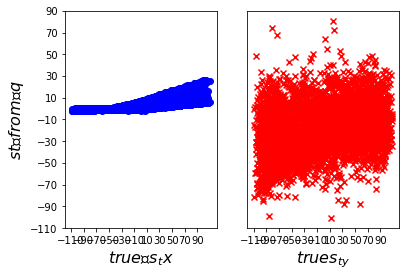

100%|██████████| 40/40 [00:00<00:00, 143.19it/s]

Epoch: 3 Train loss: 49916.3867


Test loss: 48433.7500


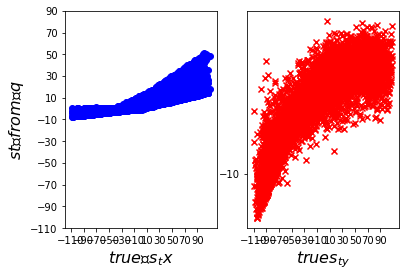

100%|██████████| 40/40 [00:00<00:00, 182.54it/s]

Epoch: 4 Train loss: 46384.0039


Test loss: 43249.5078


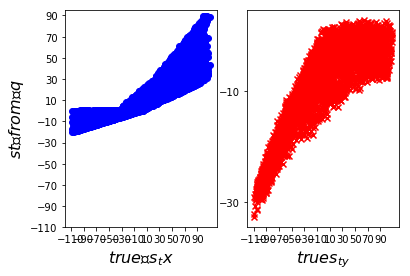

100%|██████████| 40/40 [00:00<00:00, 184.10it/s]

Epoch: 5 Train loss: 40117.8945


Test loss: 36320.1367


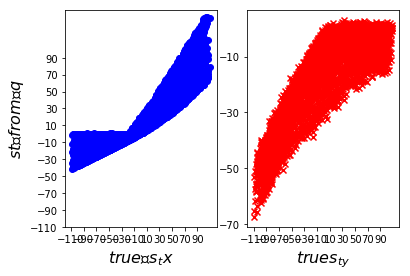

100%|██████████| 40/40 [00:00<00:00, 164.12it/s]

Epoch: 6 Train loss: 34652.7109


Test loss: 32037.7305


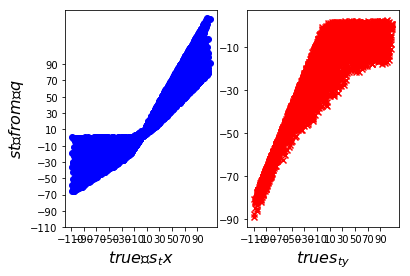

100%|██████████| 40/40 [00:00<00:00, 175.31it/s]

Epoch: 7 Train loss: 29584.6523


Test loss: 26431.6504


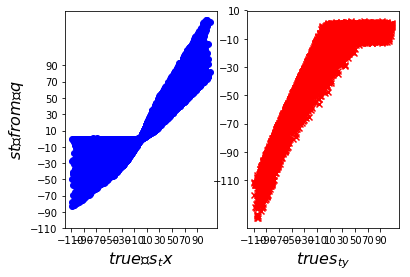

100%|██████████| 40/40 [00:00<00:00, 156.43it/s]

Epoch: 8 Train loss: 24676.8359


Test loss: 23384.0977


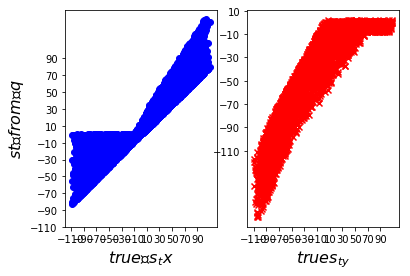

100%|██████████| 40/40 [00:00<00:00, 134.56it/s]

Epoch: 9 Train loss: 22623.2188


Test loss: 21978.0312


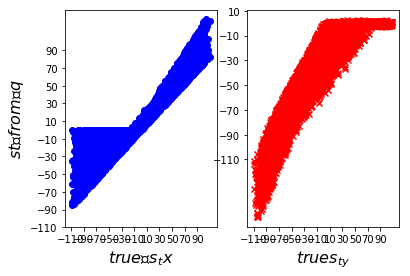

100%|██████████| 40/40 [00:00<00:00, 171.50it/s]

Epoch: 10 Train loss: 21353.6113


Test loss: 20870.5977


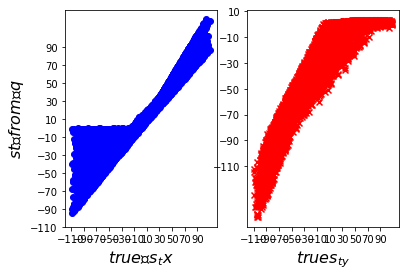

100%|██████████| 40/40 [00:00<00:00, 164.97it/s]

Epoch: 11 Train loss: 20258.4902


Test loss: 19842.1016


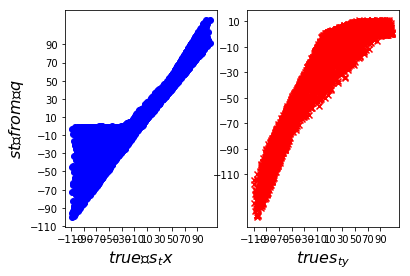

100%|██████████| 40/40 [00:00<00:00, 156.08it/s]

Epoch: 12 Train loss: 19232.1016


Test loss: 18889.7930


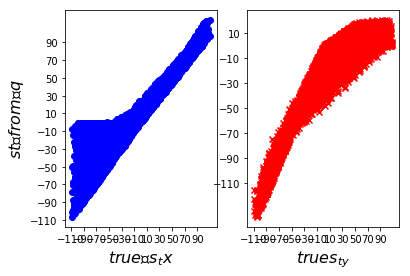

100%|██████████| 40/40 [00:00<00:00, 149.75it/s]

Epoch: 13 Train loss: 18285.1348


Test loss: 17997.1855


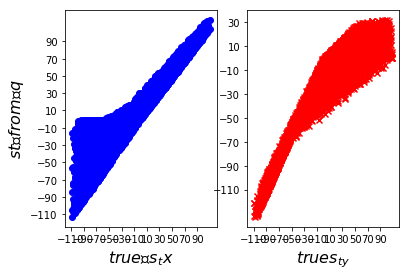

100%|██████████| 40/40 [00:00<00:00, 140.02it/s]

Epoch: 14 Train loss: 17333.8184


Test loss: 16988.7148


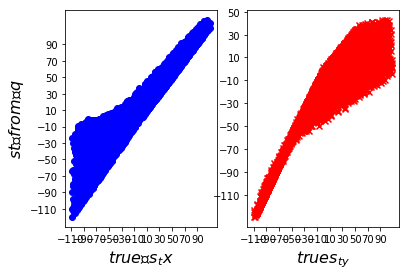

100%|██████████| 40/40 [00:00<00:00, 152.96it/s]

Epoch: 15 Train loss: 16231.6172


Test loss: 15877.7373


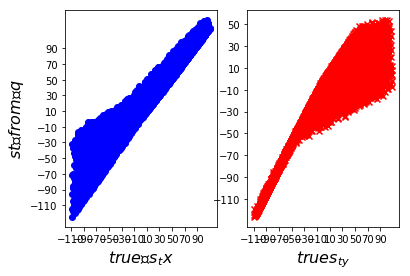

100%|██████████| 40/40 [00:00<00:00, 159.66it/s]

Epoch: 16 Train loss: 15105.6240


Test loss: 14925.4805


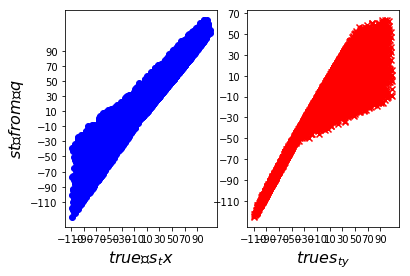

100%|██████████| 40/40 [00:00<00:00, 137.86it/s]

Epoch: 17 Train loss: 14334.3584


Test loss: 14308.9619


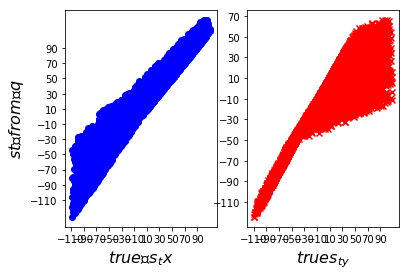

100%|██████████| 40/40 [00:00<00:00, 140.63it/s]

Epoch: 18 Train loss: 13744.6865


Test loss: 13761.2900


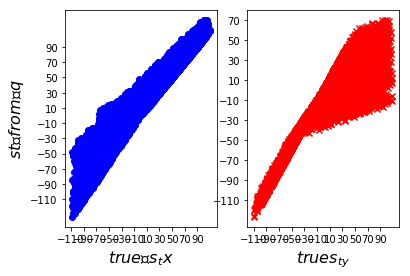

100%|██████████| 40/40 [00:00<00:00, 137.64it/s]

Epoch: 19 Train loss: 13183.9971


Test loss: 13196.1094


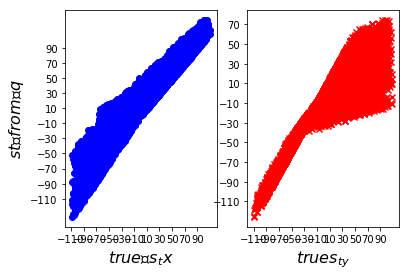

100%|██████████| 40/40 [00:00<00:00, 134.43it/s]


Epoch: 20 Train loss: 12580.2061
Test loss: 12589.0557


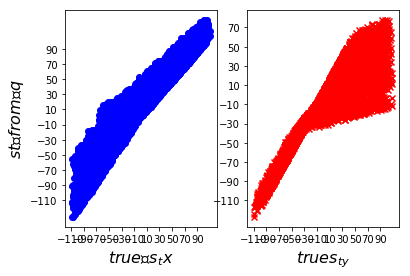

100%|██████████| 40/40 [00:00<00:00, 132.55it/s]


Epoch: 21 Train loss: 11957.3447
Test loss: 11992.4834


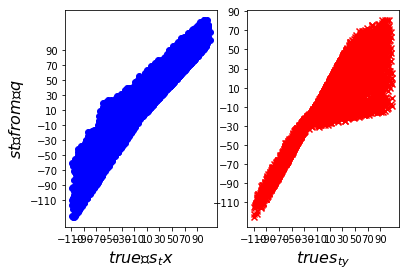

100%|██████████| 40/40 [00:00<00:00, 128.55it/s]

Epoch: 22 Train loss: 11361.2324


Test loss: 11405.3848


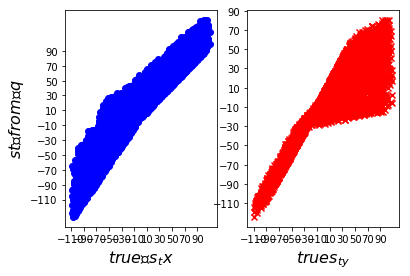

100%|██████████| 40/40 [00:00<00:00, 129.77it/s]

Epoch: 23 Train loss: 10753.8105


Test loss: 10808.4678


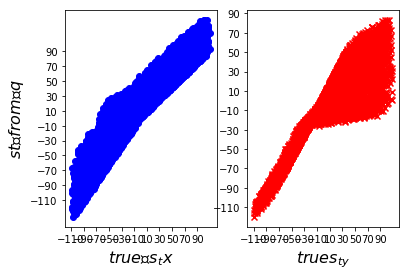

100%|██████████| 40/40 [00:00<00:00, 126.73it/s]

Epoch: 24 Train loss: 10061.6562


Test loss: 9969.5059


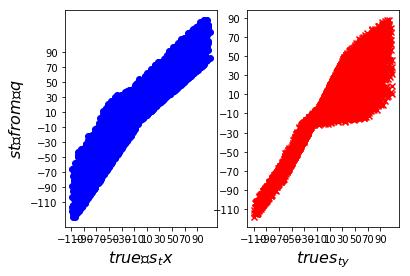

100%|██████████| 40/40 [00:00<00:00, 146.63it/s]

Epoch: 25 Train loss: 9118.3516


Test loss: 8799.3604


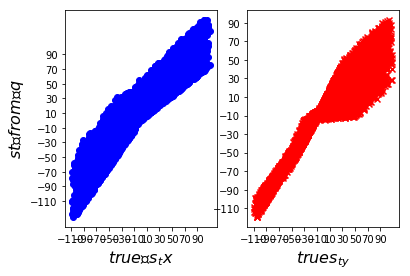

100%|██████████| 40/40 [00:00<00:00, 125.29it/s]

Epoch: 26 Train loss: 7656.0215


Test loss: 6815.0801


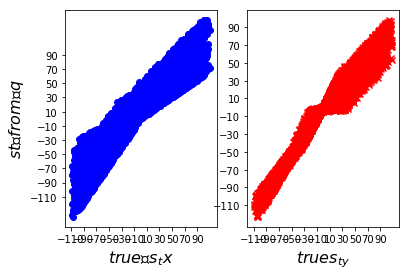

100%|██████████| 40/40 [00:00<00:00, 142.73it/s]

Epoch: 27 Train loss: 5281.8164


Test loss: 4002.7437


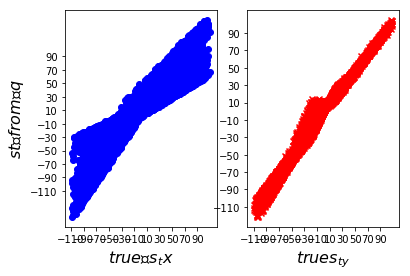

100%|██████████| 40/40 [00:00<00:00, 130.05it/s]

Epoch: 28 Train loss: 3202.3169


Test loss: 2681.1963


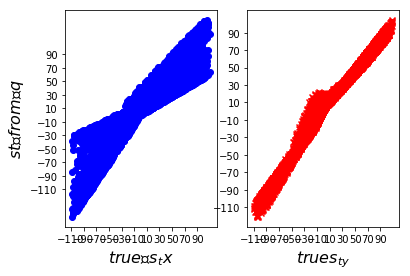

100%|██████████| 40/40 [00:00<00:00, 148.31it/s]

Epoch: 29 Train loss: 2409.7693


Test loss: 2159.3914


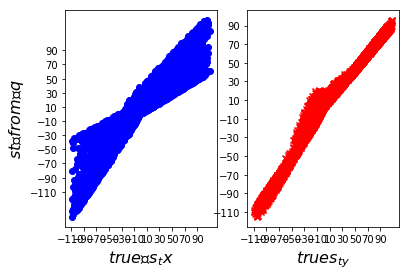

100%|██████████| 40/40 [00:00<00:00, 146.80it/s]

Epoch: 30 Train loss: 1996.4144


Test loss: 1835.7271


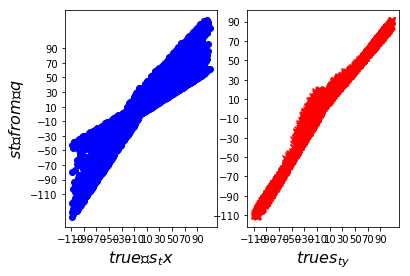

100%|██████████| 40/40 [00:00<00:00, 129.18it/s]

Epoch: 31 Train loss: 1713.9674


Test loss: 1606.3276


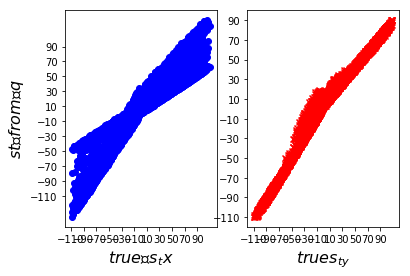

100%|██████████| 40/40 [00:00<00:00, 112.54it/s]

Epoch: 32 Train loss: 1507.5206


Test loss: 1429.7225


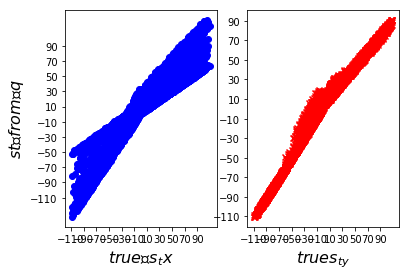

100%|██████████| 40/40 [00:00<00:00, 120.39it/s]

Epoch: 33 Train loss: 1343.3241


Test loss: 1282.4856


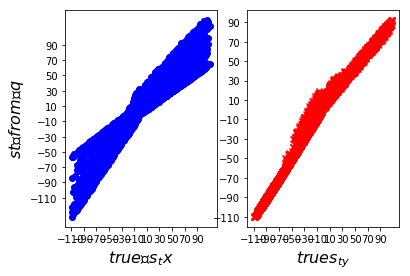

100%|██████████| 40/40 [00:00<00:00, 137.17it/s]

Epoch: 34 Train loss: 1211.5294


Test loss: 1161.8376


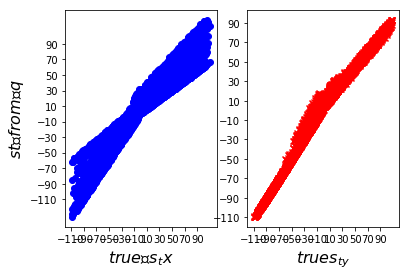

100%|██████████| 40/40 [00:00<00:00, 120.62it/s]

Epoch: 35 Train loss: 1101.4655


Test loss: 1052.9745


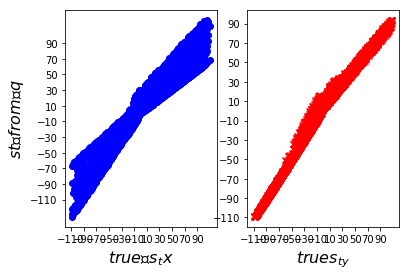

100%|██████████| 40/40 [00:00<00:00, 139.77it/s]

Epoch: 36 Train loss: 997.9235


Test loss: 951.6724


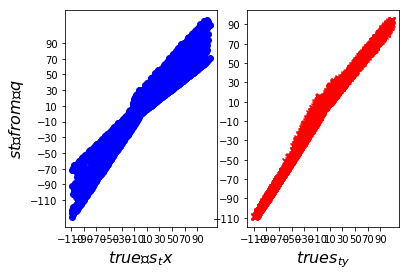

100%|██████████| 40/40 [00:00<00:00, 127.58it/s]

Epoch: 37 Train loss: 899.4637


Test loss: 854.4408


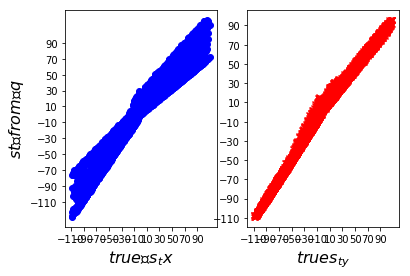

100%|██████████| 40/40 [00:00<00:00, 141.25it/s]

Epoch: 38 Train loss: 806.3591


Test loss: 762.1044


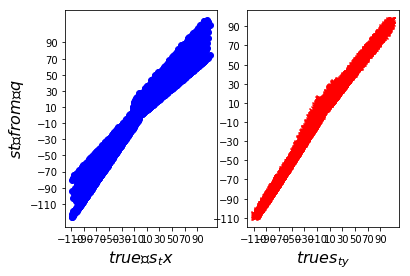

100%|██████████| 40/40 [00:00<00:00, 133.40it/s]

Epoch: 39 Train loss: 714.5344


Test loss: 671.5065


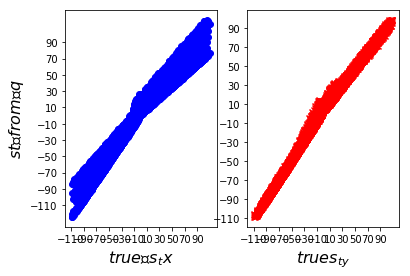

100%|██████████| 40/40 [00:00<00:00, 129.99it/s]

Epoch: 40 Train loss: 628.0203


Test loss: 587.5801


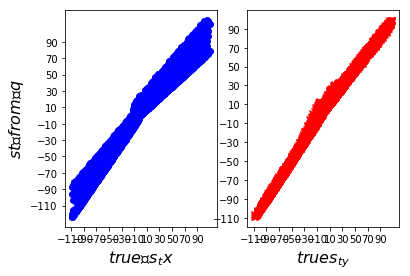

100%|██████████| 40/40 [00:00<00:00, 144.52it/s]

Epoch: 41 Train loss: 547.7284


Test loss: 508.9182


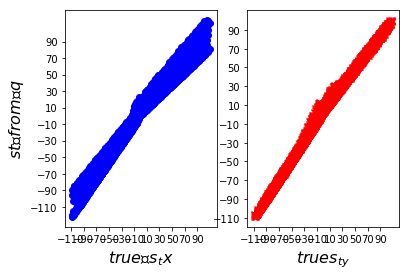

100%|██████████| 40/40 [00:00<00:00, 140.39it/s]

Epoch: 42 Train loss: 474.1732


Test loss: 437.2755


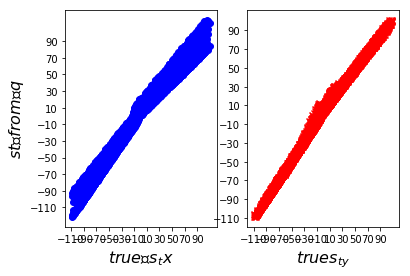

100%|██████████| 40/40 [00:00<00:00, 134.61it/s]


Epoch: 43 Train loss: 406.4319
Test loss: 373.9277


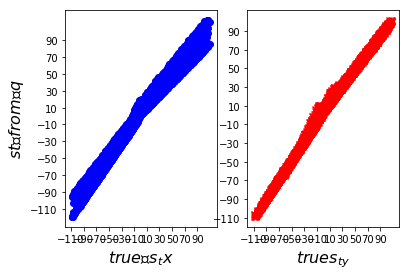

100%|██████████| 40/40 [00:00<00:00, 120.53it/s]

Epoch: 44 Train loss: 346.7950


Test loss: 317.4316


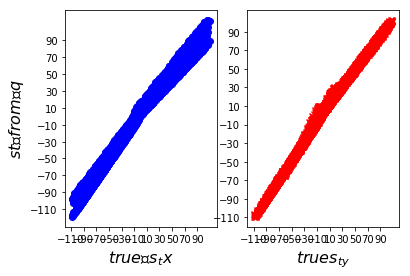

100%|██████████| 40/40 [00:00<00:00, 142.15it/s]

Epoch: 45 Train loss: 294.4740


Test loss: 269.2649


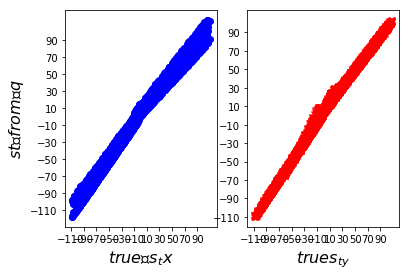

100%|██████████| 40/40 [00:00<00:00, 133.78it/s]

Epoch: 46 Train loss: 250.9902


Test loss: 229.1171


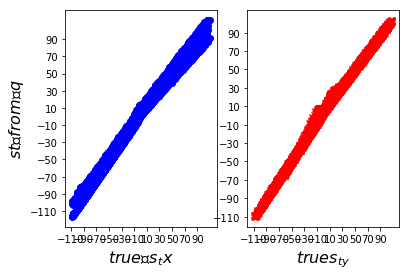

100%|██████████| 40/40 [00:00<00:00, 142.83it/s]

Epoch: 47 Train loss: 212.0224


Test loss: 193.4608


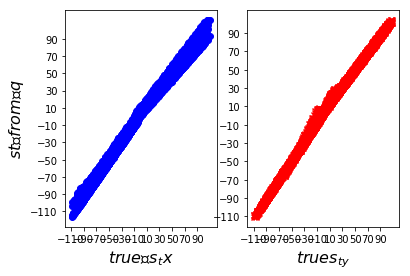

100%|██████████| 40/40 [00:00<00:00, 83.96it/s]

Epoch: 48 Train loss: 178.2803


Test loss: 163.6904


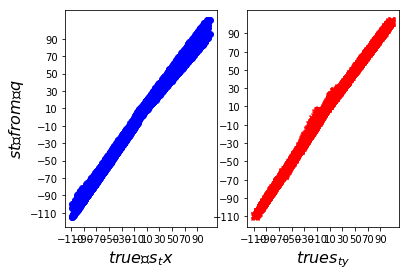

100%|██████████| 40/40 [00:00<00:00, 127.19it/s]

Epoch: 49 Train loss: 150.8185


Test loss: 138.4911


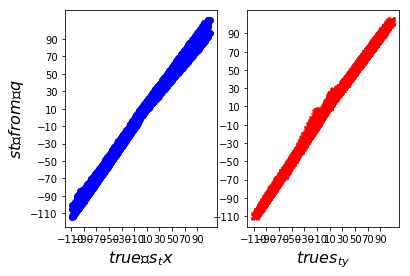

100%|██████████| 40/40 [00:00<00:00, 116.49it/s]

Epoch: 50 Train loss: 127.0612


Test loss: 117.5781


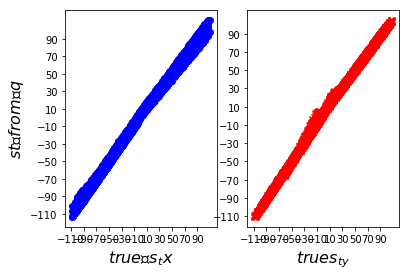

100%|██████████| 40/40 [00:00<00:00, 137.00it/s]

Epoch: 51 Train loss: 108.2591


Test loss: 100.9100


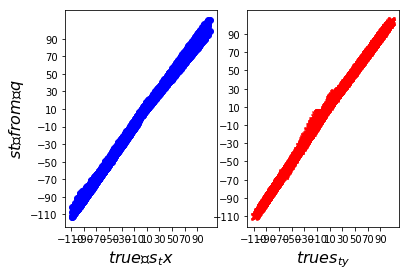

100%|██████████| 40/40 [00:00<00:00, 144.94it/s]

Epoch: 52 Train loss: 93.3038


Test loss: 87.5558


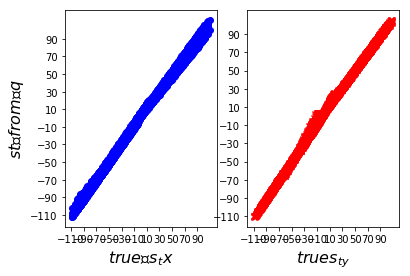

100%|██████████| 40/40 [00:00<00:00, 123.25it/s]

Epoch: 53 Train loss: 80.5673


Test loss: 76.3355


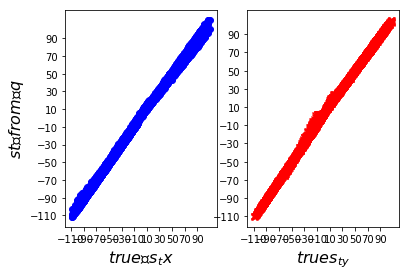

100%|██████████| 40/40 [00:00<00:00, 119.83it/s]

Epoch: 54 Train loss: 70.6943


Test loss: 67.4082


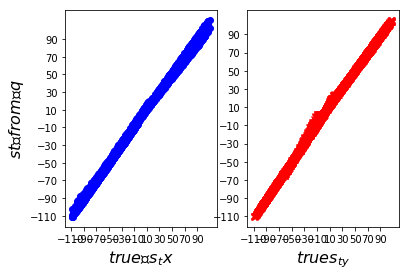

100%|██████████| 40/40 [00:00<00:00, 104.89it/s]

Epoch: 55 Train loss: 62.5925


Test loss: 60.0161


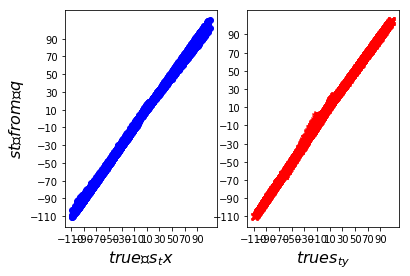

100%|██████████| 40/40 [00:00<00:00, 138.72it/s]

Epoch: 56 Train loss: 55.7407


Test loss: 54.2588


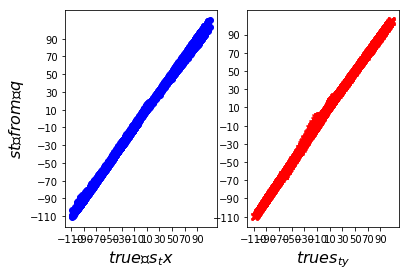

100%|██████████| 40/40 [00:00<00:00, 145.72it/s]

Epoch: 57 Train loss: 50.4196


Test loss: 49.3485


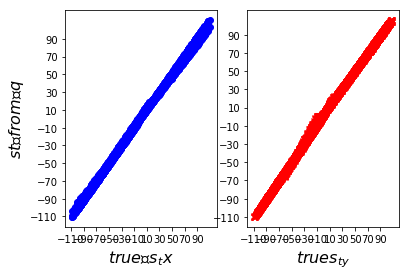

100%|██████████| 40/40 [00:00<00:00, 75.00it/s]

Epoch: 58 Train loss: 45.8100


Test loss: 44.9744


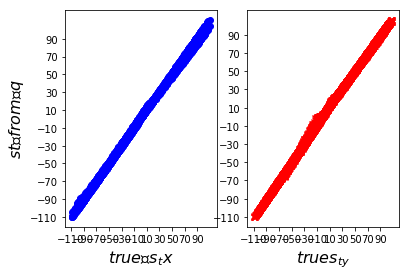

100%|██████████| 40/40 [00:00<00:00, 118.71it/s]

Epoch: 59 Train loss: 42.2428


Test loss: 41.7424


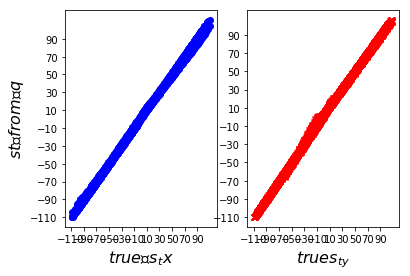

100%|██████████| 40/40 [00:00<00:00, 116.76it/s]

Epoch: 60 Train loss: 38.9105


Test loss: 38.4729


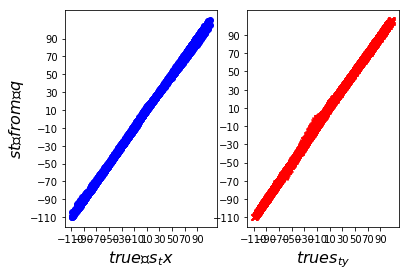

100%|██████████| 40/40 [00:00<00:00, 116.41it/s]

Epoch: 61 Train loss: 36.3818


Test loss: 36.0201


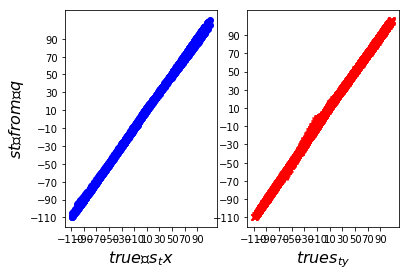

100%|██████████| 40/40 [00:00<00:00, 115.64it/s]

Epoch: 62 Train loss: 33.8963


Test loss: 33.9653


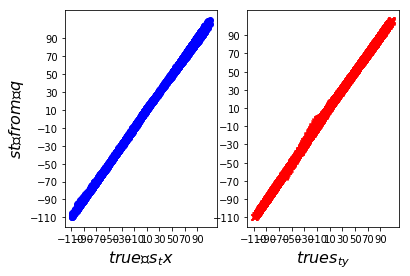

100%|██████████| 40/40 [00:00<00:00, 120.85it/s]

Epoch: 63 Train loss: 31.8479


Test loss: 31.9074


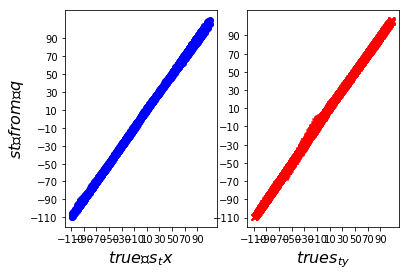

100%|██████████| 40/40 [00:00<00:00, 131.57it/s]


Epoch: 64 Train loss: 29.9301
Test loss: 30.3914


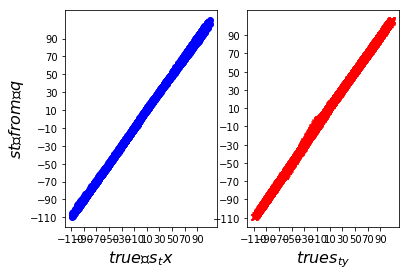

100%|██████████| 40/40 [00:00<00:00, 131.50it/s]


Epoch: 65 Train loss: 28.4234
Test loss: 28.6619


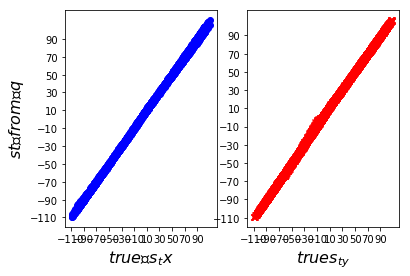

100%|██████████| 40/40 [00:00<00:00, 119.84it/s]

Epoch: 66 Train loss: 26.9668


Test loss: 27.3043


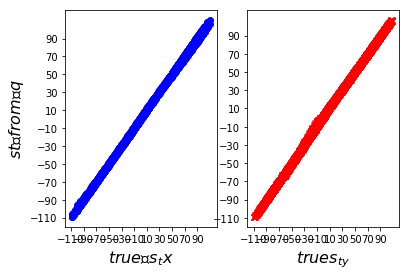

100%|██████████| 40/40 [00:00<00:00, 109.94it/s]

Epoch: 67 Train loss: 25.6778


Test loss: 25.7775


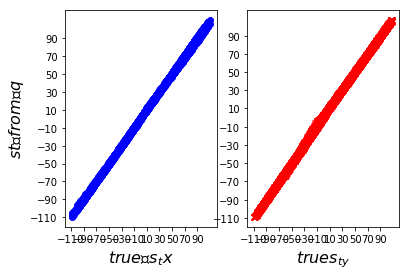

100%|██████████| 40/40 [00:00<00:00, 126.59it/s]

Epoch: 68 Train loss: 24.4514


Test loss: 24.6246


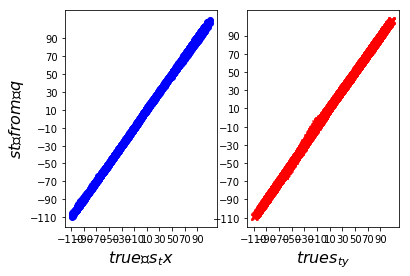

100%|██████████| 40/40 [00:00<00:00, 134.76it/s]

Epoch: 69 Train loss: 23.7003


Test loss: 23.7677


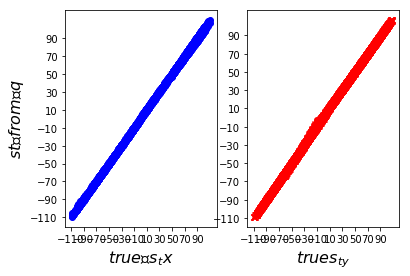

100%|██████████| 40/40 [00:00<00:00, 133.95it/s]


Epoch: 70 Train loss: 22.6492
Test loss: 22.7015


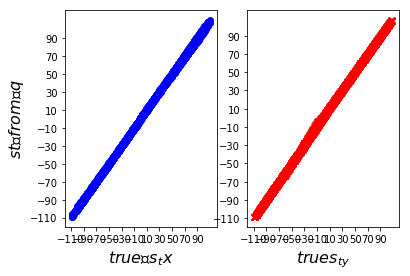

100%|██████████| 40/40 [00:00<00:00, 118.82it/s]

Epoch: 71 Train loss: 21.5728


Test loss: 21.6476


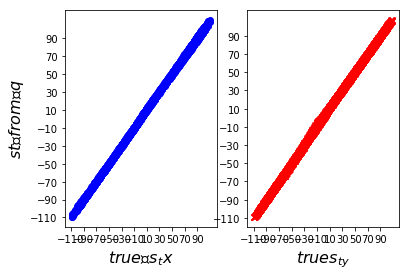

100%|██████████| 40/40 [00:00<00:00, 117.20it/s]

Epoch: 72 Train loss: 20.9718


Test loss: 21.0480


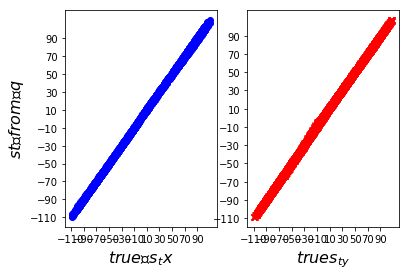

100%|██████████| 40/40 [00:00<00:00, 119.45it/s]

Epoch: 73 Train loss: 20.0721


Test loss: 20.2206


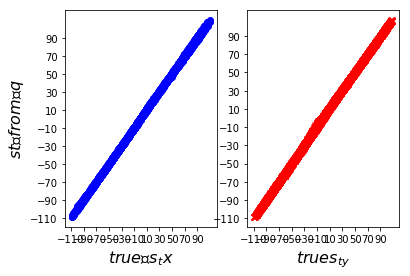

100%|██████████| 40/40 [00:00<00:00, 130.50it/s]

Epoch: 74 Train loss: 19.1840


Test loss: 19.6143


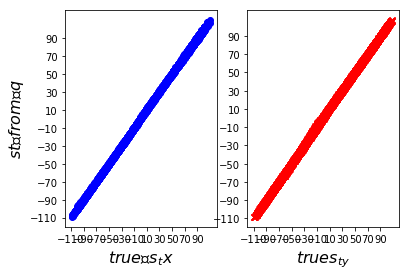

100%|██████████| 40/40 [00:00<00:00, 71.91it/s]

Epoch: 75 Train loss: 18.6898


Test loss: 18.8244


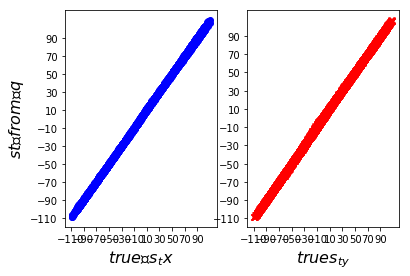

100%|██████████| 40/40 [00:00<00:00, 105.87it/s]


Epoch: 76 Train loss: 17.9727
Test loss: 17.9934


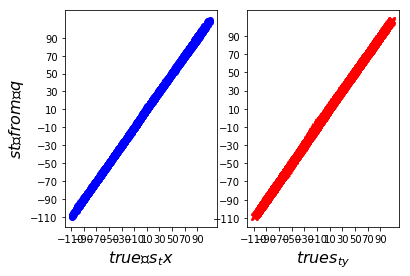

100%|██████████| 40/40 [00:00<00:00, 63.43it/s]

Epoch: 77 Train loss: 17.5296


Test loss: 17.5256


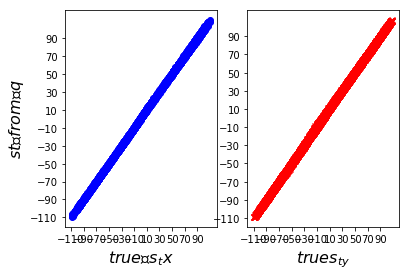

100%|██████████| 40/40 [00:00<00:00, 125.17it/s]

Epoch: 78 Train loss: 16.9418


Test loss: 16.9068


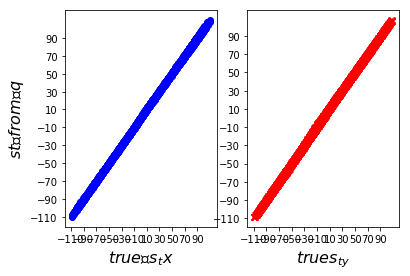

100%|██████████| 40/40 [00:00<00:00, 106.13it/s]

Epoch: 79 Train loss: 16.3522


Test loss: 16.5716


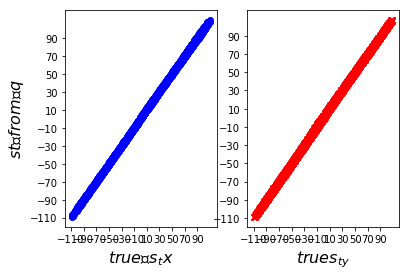

100%|██████████| 40/40 [00:00<00:00, 108.30it/s]

Epoch: 80 Train loss: 15.8793


Test loss: 15.9516


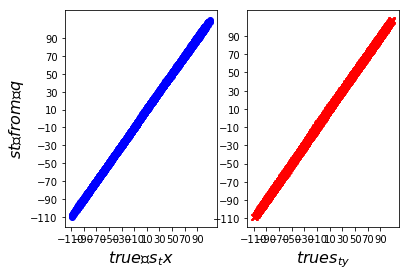

100%|██████████| 40/40 [00:00<00:00, 108.76it/s]

Epoch: 81 Train loss: 15.2471


Test loss: 15.4509


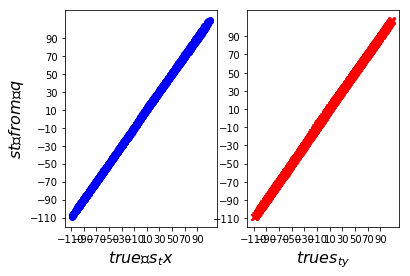

100%|██████████| 40/40 [00:00<00:00, 120.85it/s]

Epoch: 82 Train loss: 14.7393


Test loss: 14.9265


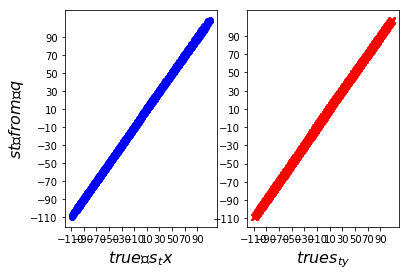

100%|██████████| 40/40 [00:00<00:00, 102.46it/s]

Epoch: 83 Train loss: 14.5109


Test loss: 14.5784


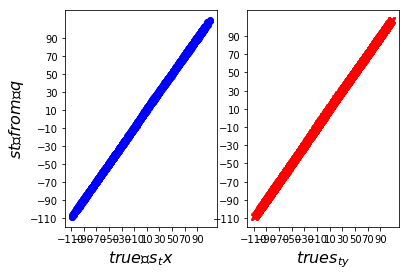

100%|██████████| 40/40 [00:00<00:00, 113.62it/s]

Epoch: 84 Train loss: 14.2920


Test loss: 14.1343


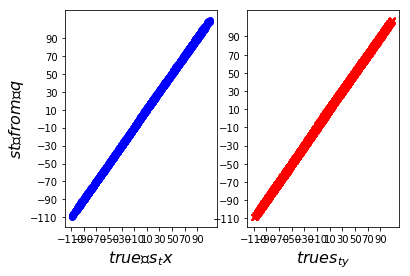

100%|██████████| 40/40 [00:00<00:00, 132.27it/s]


Epoch: 85 Train loss: 13.6861
Test loss: 13.7558


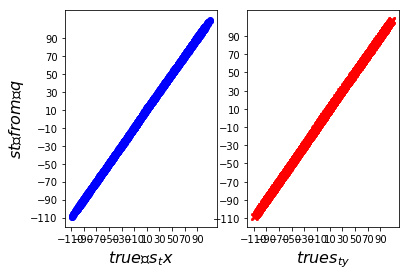

100%|██████████| 40/40 [00:00<00:00, 114.67it/s]

Epoch: 86 Train loss: 13.3884


Test loss: 13.3423


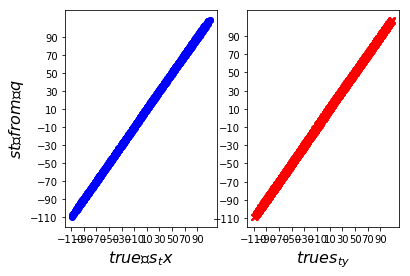

100%|██████████| 40/40 [00:00<00:00, 83.41it/s]

Epoch: 87 Train loss: 13.0334


Test loss: 12.9412


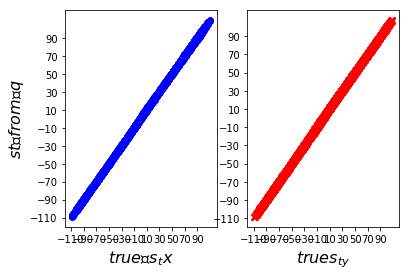

100%|██████████| 40/40 [00:00<00:00, 86.40it/s]

Epoch: 88 Train loss: 12.6125


Test loss: 12.7116


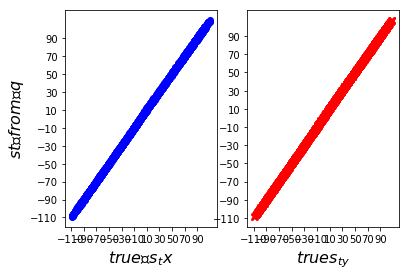

100%|██████████| 40/40 [00:00<00:00, 101.36it/s]

Epoch: 89 Train loss: 12.3607


Test loss: 12.2626


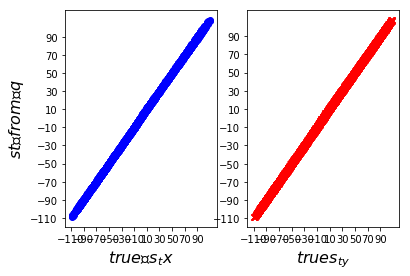

100%|██████████| 40/40 [00:00<00:00, 106.57it/s]

Epoch: 90 Train loss: 11.9924


Test loss: 12.0843


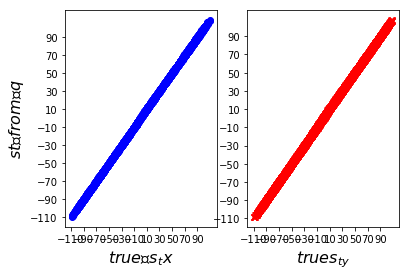

100%|██████████| 40/40 [00:00<00:00, 106.58it/s]

Epoch: 91 Train loss: 11.8185


Test loss: 11.7291


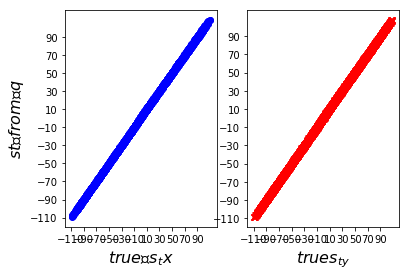

100%|██████████| 40/40 [00:00<00:00, 85.62it/s]

Epoch: 92 Train loss: 11.4007


Test loss: 11.4182


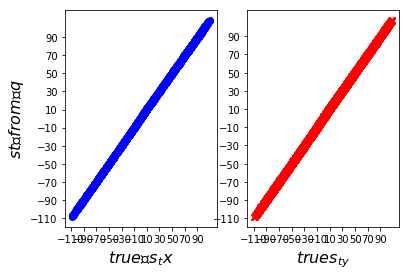

100%|██████████| 40/40 [00:00<00:00, 121.64it/s]

Epoch: 93 Train loss: 11.1229


Test loss: 11.2138


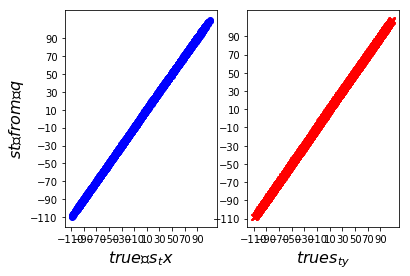

100%|██████████| 40/40 [00:00<00:00, 104.83it/s]

Epoch: 94 Train loss: 10.8221


Test loss: 10.7490


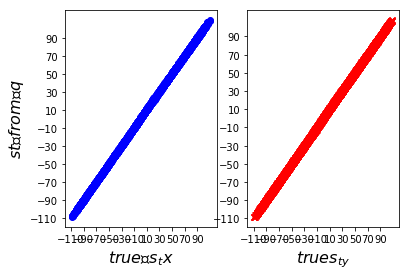

100%|██████████| 40/40 [00:00<00:00, 103.78it/s]

Epoch: 95 Train loss: 10.5276


Test loss: 10.3266


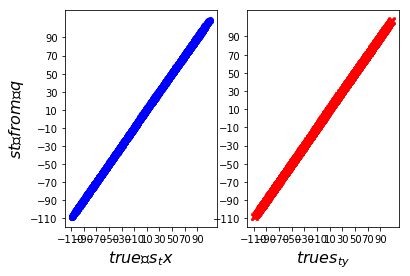

100%|██████████| 40/40 [00:00<00:00, 116.43it/s]

Epoch: 96 Train loss: 10.3461


Test loss: 10.1719


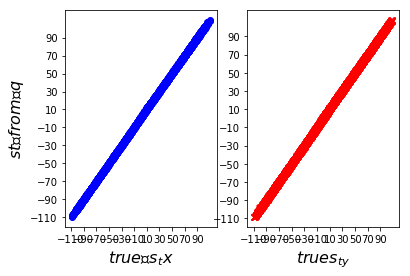

100%|██████████| 40/40 [00:00<00:00, 117.19it/s]

Epoch: 97 Train loss: 10.0747


Test loss: 9.9005


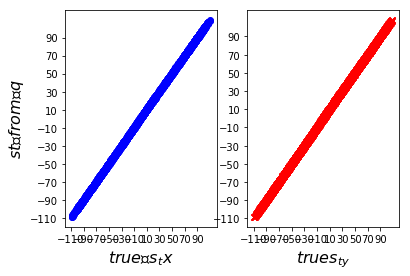

100%|██████████| 40/40 [00:00<00:00, 100.18it/s]

Epoch: 98 Train loss: 9.6238


Test loss: 9.7255


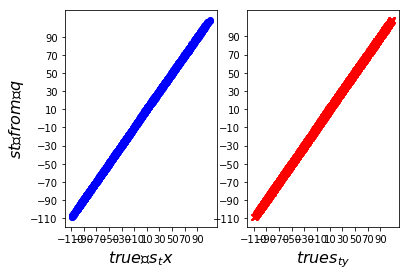

100%|██████████| 40/40 [00:00<00:00, 107.46it/s]

Epoch: 99 Train loss: 9.4408


Test loss: 9.5405


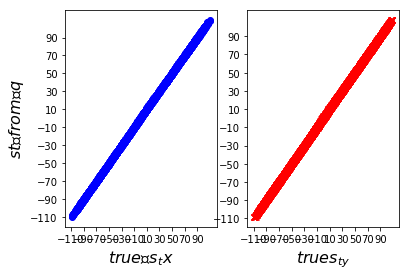

100%|██████████| 40/40 [00:00<00:00, 119.56it/s]

Epoch: 100 Train loss: 9.2718


Test loss: 9.2785


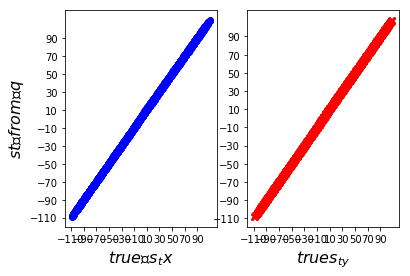

In [17]:
writer = SummaryWriter()

plot_number = 1

s_sample = 0.5 * torch.randn(64, s_dim).to(device)
c_sample = torch.eye(10)[[plot_number]*64].to(device)

# _o, _c = iter(test_loader).next()
# _o = _o.to(device)
# _c = torch.eye(10)[_c].to(device)


for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    
#     recon = plot_reconstrunction(_o[:8], _c[:8])
#     sample = plot_image_from_latent(s_sample, c_sample)
#     recon_changing_c = plot_reconstrunction_changing_c(_o[:8], _c[:8])

    writer.add_scalar('train_loss', train_loss.item(), epoch)
    writer.add_scalar('test_loss', test_loss.item(), epoch)
    
    #for plot
    history["train_loss"].append(train_loss.item())
    history["test_loss"].append(test_loss.item())

    _s = q.sample({"o": data["o"].to(device), "c": data["c"].to(device)}, return_all=False)
    plt.subplot(1, 2, 1)
    tru = plt.scatter(data["s"][:,0],_s["s"][:,0],color='blue',marker='o',edgecolors="blue")
    plt.xticks(np.arange(min_data,max_data,grid_inter))
    plt.yticks(np.arange(min_data,max_data,grid_inter))
    plt.ylabel('$st　from　q$', fontsize=16)
    plt.xlabel('$true　s_tx$', fontsize=16)
    
    plt.subplot(1, 2, 2)
    sam = plt.scatter(data["s"][:,1],_s["s"][:,1],color='red',marker='x',edgecolors="red")
    plt.xticks(np.arange(min_data,max_data,grid_inter))
    plt.yticks(np.arange(min_data,max_data,grid_inter))
    plt.xlabel('$true s_{ty}$', fontsize=16)
    ims.append([tru]+[sam])
    
    x = np.linspace(0,100,1)  # xの値域(0, 1, 2, 3)
    y = x               # 直線の式
    plt.plot(x,y,"r-")      # 直線を引く
    plt.show()
    

#     writer.add_image('Image_from_latent', sample, epoch)
#     writer.add_image('Image_reconstrunction', recon, epoch)
#     writer.add_image('Image_reconstrunction_change_c', recon_changing_c, epoch)
    
writer.close()

In [18]:
# #animation
# def iinit():    
#     return (ims[0])
# # animation function: this is called sequentially
# def animate(i):
#   return (ims[i])

# #plot gif
# fig = plt.figure()
# plt.legend(['True','Result'], loc='upper left', fontsize=16)
# ani = animation.ArtistAnimation(fig, ims)
# anim = animation.FuncAnimation(fig, animate, init_func=iinit, frames=epochs, interval=100, blit=True)
# plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
# HTML(ani.to_html5_video())
# rc('animation', html='jshtml')
# anim

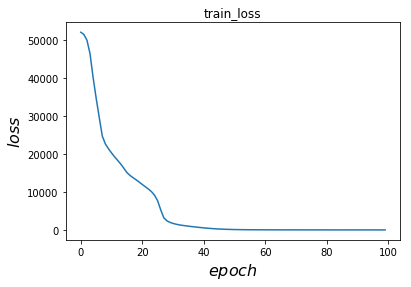

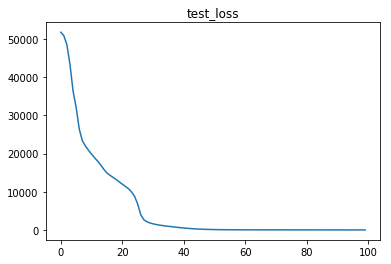

In [19]:
#plot loss    
plt.ylabel('$loss$', fontsize=16)
plt.xlabel('$epoch$', fontsize=16)
plt.title("train_loss")
plt.plot(range(epochs), history["train_loss"])
plt.show()
plt.title("test_loss")
plt.plot(range(epochs), history["test_loss"])
plt.show()

In [20]:
#u_tでの挙動をみるためのテスト
data=unique_datagenerator(sample_num,ssigma,5.0,-5.0)
_s = q.sample({"o": data["o"].to(device), "c": data["c"].to(device)}, return_all=False)
_o= p.sample({"s": _s["s"].to(device)}, return_all=False)

tensor([[-59.0003, -70.6119],
        [-16.4444, -95.7872],
        [-52.0487,  59.6190],
        ...,
        [  2.9533,  77.9271],
        [ -8.2464, -96.3349],
        [ 65.3403, -21.3098]])
tensor([[ 5., -5.],
        [ 5., -5.],
        [ 5., -5.],
        ...,
        [ 5., -5.],
        [ 5., -5.],
        [ 5., -5.]])
tensor([[ -54.0003,  -75.6119],
        [ -11.4444, -100.7872],
        [ -47.0487,   54.6190],
        ...,
        [   7.9533,   72.9271],
        [  -3.2464, -101.3349],
        [  70.3403,  -26.3098]])


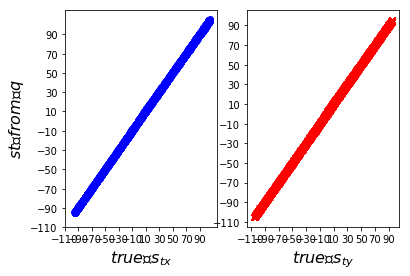

0.4275441326588392
0.34092313814461234


In [21]:
#u_tでの挙動を見るためのテストの描画
plt.subplot(1, 2, 1)
tru = plt.scatter(data["s"][:,0],_s["s"][:,0],color='blue',marker='o',edgecolors="blue")
plt.xticks(np.arange(min_data,max_data,grid_inter))
plt.yticks(np.arange(min_data,max_data,grid_inter))
plt.ylabel('$st　from　q$', fontsize=16)
plt.xlabel('$true　s_{tx}$', fontsize=16)

plt.subplot(1, 2, 2)
sam = plt.scatter(data["s"][:,1],_s["s"][:,1],color='red',marker='x',edgecolors="red")
plt.xticks(np.arange(min_data,max_data,grid_inter))
plt.yticks(np.arange(min_data,max_data,grid_inter))
plt.xlabel('$true　s_{ty}$', fontsize=16)
ims.append([tru]+[sam])
plt.grid(which='minor',color='black',linestyle='-')
plt.show()

lossx=0
lossy=0
_ss=_s["s"]
for i in range(0,sample_num-1,1):
    lossx+=np.abs(data["s"][i][0].numpy()-_ss[i][0].numpy())
    lossy+=np.abs(data["s"][i][1].numpy()-_ss[i][1].numpy())
print(lossx/sample_num)
print(lossy/sample_num)

In [22]:
print(data["s"][:,0])
print(_ss[:,0])

tensor([-53.8248, -11.4493, -46.5803,  ...,   8.3823,  -2.8907,  70.4442])
tensor([-54.3043, -11.6250, -46.5791,  ...,   8.0136,  -3.0099,  70.3039])


{'s': tensor([[ -54.3043,  -75.9699],
        [ -11.6250, -100.7280],
        [ -46.5791,   55.2145],
        ...,
        [   8.0136,   73.2458],
        [  -3.0099, -101.4828],
        [  70.3039,  -25.8067]])}
tensor([[ -54.0921,  -76.2156],
        [ -12.0793, -100.7620],
        [ -47.0532,   55.4292],
        ...,
        [   8.1586,   73.8949],
        [  -3.3536, -101.8104],
        [  70.7485,  -25.6114]])
tensor([[ -53.8248,  -75.6549],
        [ -11.4493, -100.7021],
        [ -46.5803,   54.4434],
        ...,
        [   8.3823,   73.1201],
        [  -2.8907, -101.6811],
        [  70.4442,  -25.8703]])


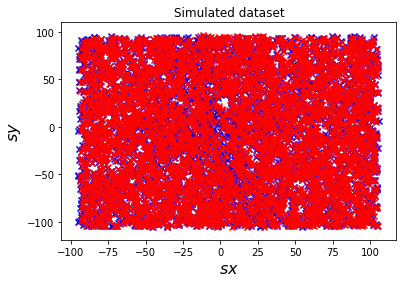

In [23]:
print(_s)
print(_o["o"])
print(data["s"])

# plt.scatter(sample_o[:,0],sample_o[:,1],color='blue',marker='o',edgecolors="blue")
plt.scatter(data["o"][:,0],data["o"][:,1],color='blue',marker='x',edgecolors="red")
plt.scatter(_o["o"][:,0],_o["o"][:,1],color='red',marker='x',edgecolors="red")
plt.xlabel('$sx$', fontsize=16)
plt.ylabel('$sy$', fontsize=16)
plt.title("Simulated dataset")
plt.show()

In [24]:
loss=0
_ss=_s["s"]
for i in range(0,sample_num-1,1):
    loss+=np.abs(data["s"][i].numpy()-_ss[i])
print(loss/sample_num)

TypeError: rsub() received an invalid combination of arguments - got (Tensor, numpy.ndarray), but expected one of:
 * (Tensor input, Tensor other, Number alpha)
 * (Tensor input, Number other, Number alpha)


In [ ]:
max_data=10#max_data
min_data=-4#min_data
grid_inter=1

plot_data=test_data

_s = q.sample({"o": plot_data["o"].to(device), "c": plot_data["c"].to(device)}, return_all=False)

#show sample points
plt.scatter(plot_data["s"][:,0],plot_data["s"][:,1],color='blue',marker='o',edgecolors="blue")
plt.scatter(_s["s"][:,0],_s["s"][:,1],color='red',marker='x',edgecolors="red")
plt.xlabel('$sx$', fontsize=16)
plt.ylabel('$sy$', fontsize=16)
plt.title("Simulated dataset")
plt.show()

plt.subplot(1, 2, 1)
plt.scatter(plot_data["s"][:,0],plot_data["s"][:,1],color='blue',marker='o',edgecolors="blue")
plt.xticks(np.arange(min_data-1,max_data+1,grid_inter))
plt.subplot(1,2,2)
plt.scatter(_s["s"][:,0],_s["s"][:,1],color='red',marker='x',edgecolors="red")
plt.xticks(np.arange(min_data-1,max_data+1,grid_inter))
plt.show()
